## Analyse exploratoire : statistiques agrégées par question

In [24]:
import pandas as pd

# Charger et préparer les données
df = pd.read_csv("/Users/ahmadouaidara/Downloads/Technical Assesment Vera Health – Dataset - Vera_OE_Dataset.csv")
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")

# Agrégation par question
grouped = df.groupby("question").agg(
    avg_impact_factor=("impact_factor", "mean"),
    max_impact_factor=("impact_factor", "max"),
    min_impact_factor=("impact_factor", "min"),
    unique_journals=("journal", "nunique"),
    num_articles=("references", "count")
).reset_index()

# Affichage
print("\n Aperçu des statistiques par question :\n")
print(grouped.head())


 Aperçu des statistiques par question :

                                            question  avg_impact_factor  \
0  Q1- Should I use beta blocker in a patient wit...           3.406611   
1  Q10- what does fenofibrate do for patients wit...           0.976625   
2  Q11- what to do for incidental IPMN in 79 year...           3.523368   
3  Q2- What test is used to confirm celiac diseas...           4.358118   
4  Q3- What are the latest guidelines for HPV vac...          17.699813   

   max_impact_factor  min_impact_factor  unique_journals  num_articles  
0              8.145              0.000               14            18  
1              4.091              0.000               14            16  
2             20.145              0.580               17            19  
3              9.761              0.000               12            17  
4            107.000              0.682               13            16  


## Construction des features et calcul du score personnalisé

In [25]:
# Nettoyer les colonnes
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")
df = df.copy()

# Remplir les NaN par 0 pour éviter erreurs
df.fillna(0, inplace=True)

# Normalisations manuelles selon les seuils fournis
def normalize_by_threshold(value, thresholds):
    thresholds = dict(sorted(thresholds.items()))
    keys = list(thresholds.keys())
    for i in range(len(keys) - 1):
        if keys[i] <= value < keys[i + 1]:
            return thresholds[keys[i]]
    return thresholds[keys[-1]] if value >= keys[-1] else 0

# Dictionnaires de normalisation
sjr_norm = {
    50: 0.1, 60: 0.2, 70: 0.3, 80: 0.4, 90: 0.5,
    95: 0.6, 96: 0.7, 97: 0.8, 98: 0.9, 99: 1
}
cit_per_year_norm = {
    81: 0.1, 83: 0.2, 85: 0.3, 87: 0.4, 89: 0.5,
    91: 0.6, 93: 0.7, 95: 0.8, 97: 0.9, 99: 1
}
infl_cit_norm = {
    81: 0.2, 89: 0.4, 95: 0.6, 96: 0.7, 97: 0.8,
    98: 0.9, 99: 1
}

# Application des normalisations
df["normalized_impact_factor"] = df["impact_factor"].apply(lambda x: normalize_by_threshold(x, sjr_norm))
df["normalized_citations_per_year"] = df["#citations/year"].apply(lambda x: normalize_by_threshold(x, cit_per_year_norm))
df["normalized_influential_citations"] = df["#influential_citations"].apply(lambda x: normalize_by_threshold(x, infl_cit_norm))

# Score de type de publication (1 si guideline)
df["publication_type_score"] = df["type"].str.lower().str.contains("guideline|recommendation").astype(int)

# Score récence (binaire) et pénalité année
df["year_binary"] = df["year"].apply(lambda x: 1 if x > 2016 else 0)
df["year_penalty"] = df["year"].apply(lambda y: -0.2 if y < 2000 else (-0.1 if y < 2010 else 0))
# Score récence (binaire) et pénalité année
df["year_binary"] = df["year"].apply(lambda x: 1 if x > 2016 else 0)
df["year_penalty"] = df["year"].apply(lambda y: -0.2 if y < 2000 else (-0.1 if y < 2010 else 0))
df["recency_score"] = df["year_binary"] + df["year_penalty"]
# Calcul du score de citations
df["citation_score"] = 0.75 * df["normalized_citations_per_year"] + 0.25 * df["normalized_influential_citations"]

# Pondérations personnalisées
weights = {
    "PUBLICATION_TYPE": 0.25,
    "IMPACT_FACTOR": 0.45,
    "CITATIONS": 0.1,
    "PUBLICATION_YEAR": 0.2
}

# Score final
df["custom_weighted_score"] = (
    weights["PUBLICATION_TYPE"] * df["publication_type_score"] +
    weights["IMPACT_FACTOR"] * df["normalized_impact_factor"] +
    weights["CITATIONS"] * df["citation_score"] +
    weights["PUBLICATION_YEAR"] * df["year_binary"] +
    df["year_penalty"]
)

# Résultat top 10
top_articles = df[[
    "question", "journal", "impact_factor", "year", "type",
    "normalized_impact_factor", "normalized_citations_per_year", "normalized_influential_citations",
    "publication_type_score", "year_binary", "year_penalty",
    "citation_score", "custom_weighted_score"
]].sort_values(by="custom_weighted_score", ascending=False).head(10)

top_articles.reset_index(drop=True, inplace=True)
top_articles.head(10)

,question,journal,impact_factor,year,type,normalized_impact_factor,normalized_citations_per_year,normalized_influential_citations,publication_type_score,year_binary,year_penalty,citation_score,custom_weighted_score
0,Q3- What are the latest guidelines for HPV vac...,CA: A Cancer Journal for Clinicians,107.000,2020.0,Guideline,1,1.0,0.0,1,1,0.0,0.75,0.975
1,Q3- What are the latest guidelines for HPV vac...,CA: a cancer journal for clinicians,107.000,2020.0,Guideline,1,0.0,0.0,1,1,0.0,0.00,0.900
2,Q3- What are the latest guidelines for HPV vac...,Morbidity and Mortality Weekly Report,13.080,2019.0,Guideline,0,1.0,0.0,1,1,0.0,0.75,0.525
3,Q3- What are the latest guidelines for HPV vac...,JAMA dermatology,3.203,2020.0,Guideline,0,0.0,0.0,1,1,0.0,0.00,0.450
4,Q3- What are the latest guidelines for HPV vac...,Investigative and Clinical Urology,0.682,2024.0,Guideline,0,0.0,0.0,1,1,0.0,0.00,0.450
5,Q3- What are the latest guidelines for HPV vac...,Cancer,2.887,2021.0,Guideline,0,0.0,0.0,1,1,0.0,0.00,0.450
6,Q3- What are the latest guidelines for HPV vac...,Obstetrics & Gynecology,2.032,2020.0,Guideline,0,0.0,0.0,1,1,0.0,0.00,0.450
7,Q3- What are the latest guidelines for HPV vac...,Obstetrics and gynecology,2.032,2017.0,Guideline,0,0.0,0.0,1,1,0.0,0.00,0.450
8,Q3- What are the latest guidelines for HPV vac...,Obstetrics & Gynecology,2.032,2017.0,Guideline,0,0.0,0.0,1,1,0.0,0.00,0.450
9,Q3- What are the latest guidelines for HPV vac...,Journal of Gynecologic Oncology,1.049,2019.0,Guideline,0,0.0,0.0,1,1,0.0,0.00,0.450


## Évaluation de performance : précision du ranking (MSE) et pertinence (NDCG)

In [26]:
import sklearn
from sklearn.metrics import mean_squared_error
from sklearn.metrics import ndcg_score
# Conversion des classements en numérique (au cas où certaines valeurs sont mal typées)
df["ranking_physician_1"] = pd.to_numeric(df["ranking_physician_1"], errors="coerce")
df["ranking_physician_2"] = pd.to_numeric(df["ranking_physician_2"], errors="coerce")
df["ranking_physician_3"] = pd.to_numeric(df["ranking_physician_3"], errors="coerce")

# Création du score de référence : moyenne des classements des 3 médecins
df["gold_standard_rank"] = df[[
    "ranking_physician_1",
    "ranking_physician_2",
    "ranking_physician_3"
]].mean(axis=1)
# Filtrer les valeurs valides
df_filtered = df[["question", "custom_weighted_score", "gold_standard_rank"]].dropna()

# Calcul de l’erreur quadratique moyenne
mse = mean_squared_error(df_filtered["gold_standard_rank"], -df_filtered["custom_weighted_score"])

# Calcul du NDCG par question
ndcg_results = {}
for q, group in df_filtered.groupby("question"):
    true_relevance = group["gold_standard_rank"].rank(ascending=False).values.reshape(1, -1)
    predicted_scores = group["custom_weighted_score"].values.reshape(1, -1)
    score = ndcg_score(true_relevance, predicted_scores)
    ndcg_results[q] = score

# Moyenne globale du NDCG
mean_ndcg = sum(ndcg_results.values()) / len(ndcg_results)

# Résumé des résultats
evaluation_results = {
    "Mean Squared Error (global)": mse,
    "Mean NDCG across questions": mean_ndcg,
    "NDCG by question": ndcg_results
}

evaluation_results

{'Mean Squared Error (global)': 50.4027169994213,
 'Mean NDCG across questions': np.float64(0.8422711440015145),
 'NDCG by question': {'Q1- Should I use beta blocker in a patient with hfpef snd grade 3 diastolic dysfunction': np.float64(0.7840968422412758),
  'Q10- what does fenofibrate do for patients with high or ineffective hdl': np.float64(0.8759324223026093),
  'Q11- what to do for incidental IPMN in 79 year old': np.float64(0.909115597391393),
  'Q2- What test is used to confirm celiac disease in adults': np.float64(0.902143075897061),
  'Q3- What are the latest guidelines for HPV vaccination': np.float64(0.8341802182576779),
  "Q4- Are there any biopsy protocols for assessing histologic recurrence of Crohn's disease after ileocecectomy in a standardized way?": np.float64(0.8263570040250102),
  'Q5- When is amoxicillin/clavulanate preferred over amoxicillin for AOM?': np.float64(0.8105381253712434),
  'Q6- Which mallampati score is lowest eisk': np.float64(0.7834869938820369),
  

## Optimisation automatique des pondérations (MSE & NDCG)

In [27]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, ndcg_score
from scipy.optimize import minimize, differential_evolution

#  Chargement et préparation des données
file_path = "/Users/ahmadouaidara/Downloads/Technical Assesment Vera Health – Dataset - Vera_OE_Dataset.csv"
df = pd.read_csv(file_path)
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_").str.replace("#", "").str.replace("/", "_")
df.fillna(0, inplace=True)

# Corriger automatiquement le nom de colonne si besoin
if "citations_per_year_normalized" not in df.columns and "citations_year_normalized" in df.columns:
    df["citations_per_year_normalized"] = df["citations_year_normalized"]

# Calculer citation_score
df["citation_score"] = 0.75 * df["citations_per_year_normalized"] + 0.25 * df["influential_citations_normalized"]
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_").str.replace("#", "").str.replace("/", "_")
df.fillna(0, inplace=True)

# Calcul du score de citation
df["citation_score"] = 0.75 * df["citations_per_year_normalized"] + 0.25 * df["influential_citations_normalized"]

# Nettoyage des rangs
for col in ["ranking_physician_1", "ranking_physician_2", "ranking_physician_3"]:
    df[col] = pd.to_numeric(df[col], errors="coerce")

df["gold_standard_rank"] = df[[
    "ranking_physician_1", "ranking_physician_2", "ranking_physician_3"
]].mean(axis=1)

df = df.dropna(subset=["gold_standard_rank"])

# === ⚙️ Application des poids
def apply_weights(weights, df):
    w1, w2, w3, w4 = weights
    return (
        w1 * df["publication_type_score"] +
        w2 * df["impact_factor_normalized"] +
        w3 * df["citation_score"] +
        w4 * df["year_binary"]
    )

# Optimisation 1 : minimisation du MSE global
def scoring_function_mse(weights):
    score = apply_weights(weights, df)
    return mean_squared_error(df["gold_standard_rank"], -score)

constraints = {"type": "eq", "fun": lambda w: sum(w) - 1}
bounds = [(0, 1)] * 4
initial_weights = [0.25, 0.45, 0.1, 0.2]

result_mse = minimize(scoring_function_mse, initial_weights, bounds=bounds, constraints=constraints)
optimized_weights_mse = result_mse.x
final_mse = result_mse.fun

# Optimisation 2 : maximisation du NDCG moyen
def scoring_function_ndcg(weights):
    weights = weights / sum(weights)
    df["score_temp"] = apply_weights(weights, df)

    ndcg_scores = []
    for _, group in df.groupby("question"):
        if len(group) < 2:
            continue
        true = group["gold_standard_rank"].rank(ascending=False).values.reshape(1, -1)
        pred = group["score_temp"].values.reshape(1, -1)
        ndcg_scores.append(ndcg_score(true, pred))

    return -np.mean(ndcg_scores)

result_ndcg = differential_evolution(scoring_function_ndcg, [(0.05, 1.0)] * 4)
optimized_weights_ndcg = result_ndcg.x / sum(result_ndcg.x)

# Score NDCG final
df["score_ndcg"] = apply_weights(optimized_weights_ndcg, df)
ndcg_scores = []
for _, group in df.groupby("question"):
    if len(group) < 2:
        continue
    true = group["gold_standard_rank"].rank(ascending=False).values.reshape(1, -1)
    pred = group["score_ndcg"].values.reshape(1, -1)
    ndcg_scores.append(ndcg_score(true, pred))
final_ndcg = np.mean(ndcg_scores)

# Résumé des résultats
print(" Résultats finaux")
print("\n Optimisation MSE")
print("Poids :", np.round(optimized_weights_mse, 4))
print("MSE global :", round(final_mse, 4))

print("\n Optimisation NDCG")
print("Poids :", np.round(optimized_weights_ndcg, 4))
print("NDCG moyen :", round(final_ndcg, 4))

 Résultats finaux

 Optimisation MSE
Poids : [0. 0. 1. 0.]
MSE global : 53.6643

 Optimisation NDCG
Poids : [0.0636 0.187  0.5914 0.158 ]
NDCG moyen : 0.902


In [28]:
print("Résultats comparés :\n")

print(" MSE Optimization")
print("Weights :", optimized_weights_mse)
print("Final MSE :", final_mse)

print("\n NDCG Optimization")
print("Weights :", optimized_weights_ndcg)
print("Final NDCG :", final_ndcg)

Résultats comparés :

 MSE Optimization
Weights : [0.00000000e+00 6.66133815e-16 1.00000000e+00 0.00000000e+00]
Final MSE : 53.66432798032408

 NDCG Optimization
Weights : [0.06359934 0.18700085 0.59143172 0.15796809]
Final NDCG : 0.9020315626492793


/var/folders/bx/k_6828rx3rg5trv33q12x62r0000gn/T/ipykernel_12044/3582176454.py:63: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


<Figure size 1200x600 with 0 Axes>

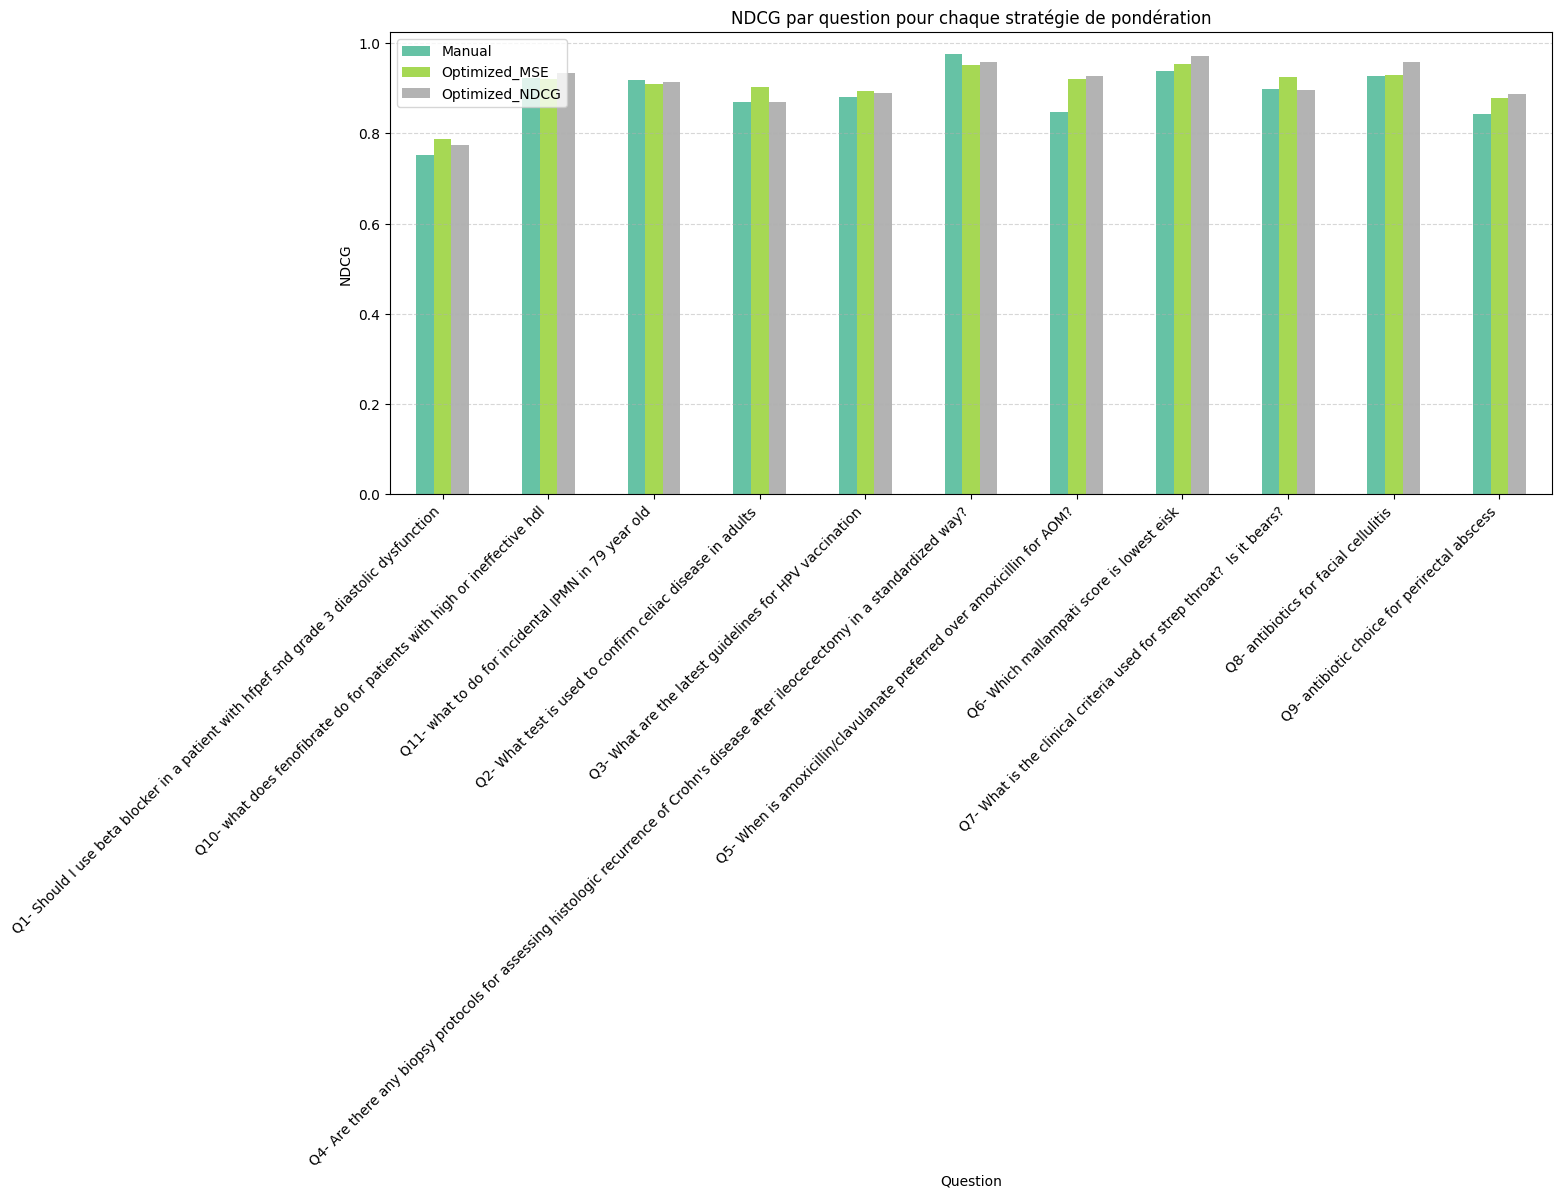


 Moyenne MSE par stratégie :
Manual            0.888186
Optimized_MSE     0.906382
Optimized_NDCG    0.907183
dtype: float64


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ndcg_score, mean_squared_error

# Convertir les colonnes de ranking si ce n'est pas déjà fait
for col in ["ranking_physician_1", "ranking_physician_2", "ranking_physician_3"]:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# Calcul du gold standard
df["gold_standard_rank"] = df[[
    "ranking_physician_1", "ranking_physician_2", "ranking_physician_3"
]].mean(axis=1)

# Stratégies de pondérations
weight_sets = {
    "Manual": [0.25, 0.45, 0.10, 0.20],
    "Optimized_MSE": [0.0, 0.0, 1.0, 0.0],
    "Optimized_NDCG": [0.03835211, 0.13271434, 0.6491585, 0.17977505]
}
df["year_binary"] = df["year"].apply(lambda x: 1 if x > 2016 else 0)
df["year_penalty"] = df["year"].apply(lambda y: -0.2 if y < 2000 else (-0.1 if y < 2010 else 0))
df["recency_score"] = df["year_binary"] + df["year_penalty"]  # ✅ ligne essentielle

# Fonction pour calculer le score pondéré
def compute_weighted_score(row, weights):
    w1, w2, w3, w4 = weights
    return (
        w1 * row["publication_type_score"] +
        w2 * row["impact_factor_normalized"] +
        w3 * row["citation_score"] +
        w4 * row["recency_score"]
    )

# Calcul des NDCG par question pour chaque stratégie
ndcg_per_question_all = {}

for strategy, weights in weight_sets.items():
    df[f"score_{strategy}"] = df.apply(lambda row: compute_weighted_score(row, weights), axis=1)
    ndcg_by_question = {}
    
    for q, group in df.dropna(subset=["gold_standard_rank"]).groupby("question"):
        # Donne un score de pertinence inversé, puis remet à l’échelle entre 0 et 1
        ranked = group["gold_standard_rank"].rank(method="first", ascending=True)
        true_relevance = (ranked.max() - ranked + 1).values.reshape(1, -1)
        predicted_score = group[f"score_{strategy}"].values.reshape(1, -1)
        ndcg = ndcg_score(true_relevance, predicted_score)
        ndcg_by_question[q] = ndcg

    ndcg_per_question_all[strategy] = ndcg_by_question

# Affichage sous forme de DataFrame
ndcg_df = pd.DataFrame(ndcg_per_question_all).sort_index()

# Tracer le graphique
plt.figure(figsize=(12, 6))
ndcg_df.plot(kind="bar", figsize=(15, 6), colormap="Set2")
plt.title("NDCG par question pour chaque stratégie de pondération")
plt.ylabel("NDCG")
plt.xlabel("Question")
plt.xticks(rotation=45, ha='right')
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
# Moyennes globales
print("\n Moyenne NDCG par stratégie :")
print(ndcg_df.mean())

/var/folders/bx/k_6828rx3rg5trv33q12x62r0000gn/T/ipykernel_12044/754656923.py:44: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


<Figure size 1400x600 with 0 Axes>

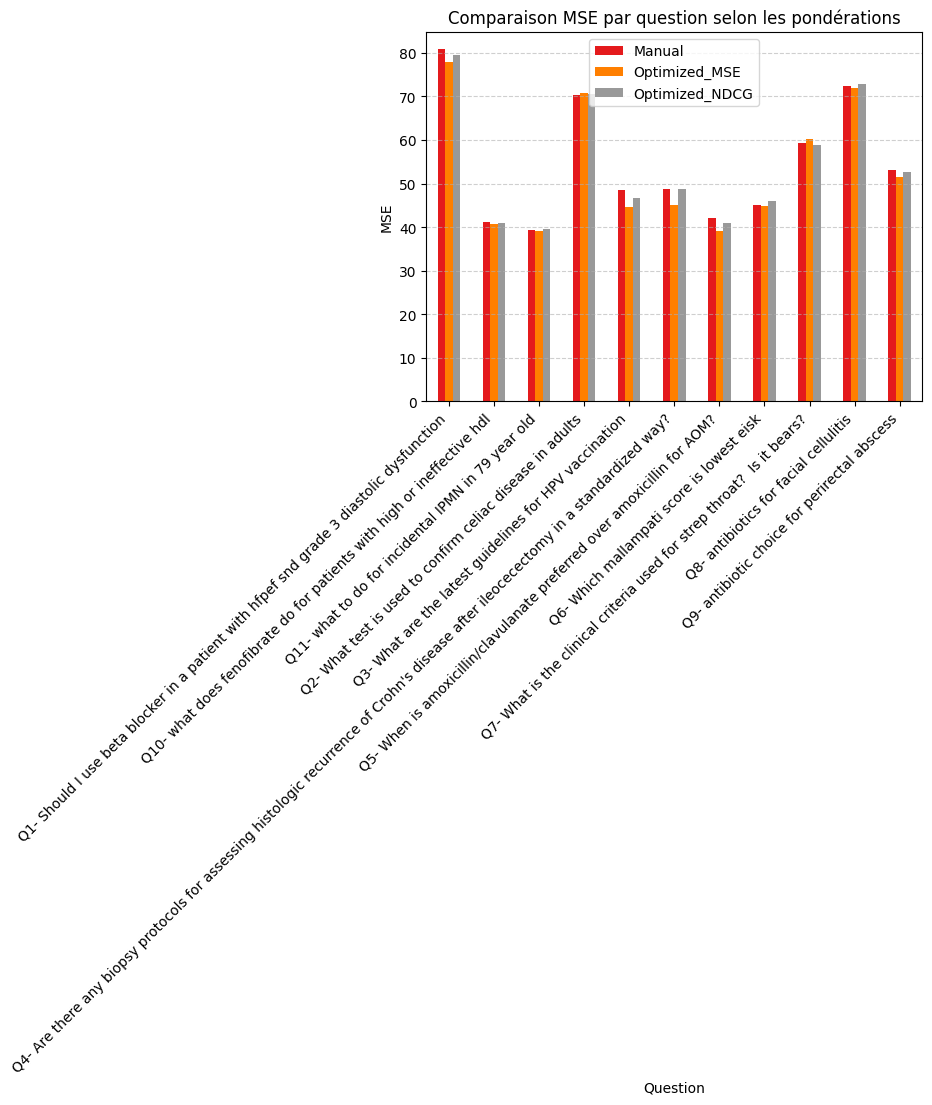


 Moyenne MSE par stratégie :
Manual            54.653452
Optimized_MSE     53.265377
Optimized_NDCG    54.314004
dtype: float64


In [32]:
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Repartir du même DataFrame déjà prétraité (df doit contenir les colonnes nécessaires)
weights_sets = {
    "Manual": [0.25, 0.45, 0.10, 0.20],
    "Optimized_MSE": [0.0, 0.0, 1.0, 0.0],
    "Optimized_NDCG": [0.13098741, 0.06014494, 0.5444395, 0.26442814]
}

mse_results = {}

for name, weights in weights_sets.items():
    w1, w2, w3, w4 = weights
    df[f"score_{name}"] = (
        w1 * df["publication_type_score"] +
        w2 * df["impact_factor_normalized"] +
        w3 * df["citation_score"] +
        w4 * df["year_binary"]
    )

    mse_per_question = {}
    for q, group in df.groupby("question"):
        if len(group) < 2:
            continue
        mse = mean_squared_error(group["gold_standard_rank"], -group[f"score_{name}"])
        mse_per_question[q] = mse

    mse_results[name] = mse_per_question

# Convertir en DataFrame
mse_df = pd.DataFrame(mse_results).sort_index()

# Graphique de comparaison
plt.figure(figsize=(14, 6))
mse_df.plot(kind='bar', colormap="Set1")
plt.title("Comparaison MSE par question selon les pondérations")
plt.ylabel("MSE")
plt.xlabel("Question")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

# Moyennes globales
print("\n Moyenne MSE par stratégie :")
print(mse_df.mean())